<a href="https://colab.research.google.com/github/moch1996/Vaycold/blob/main/Python_DL/%EC%84%B1%EB%B3%84%EA%B3%BC%20%EC%9B%83%EC%9D%8C%EC%9D%84%20%EB%8F%99%EC%8B%9C%EC%97%90%20%ED%8C%90%EB%8B%A8%ED%95%98%EB%8A%94%20%EB%AA%A8%EB%8D%B8.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### 데이터셋 : celeba dataset
 - 큰 사진을 작게 줄이기
 - 한 모델에서 여러 결과에 대한 분석시행

## 라이브러리

In [1]:
import tensorflow as tf
from tensorflow import keras
from keras.layers import Dense
from keras.models import Sequential

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

from IPython.display import Image

warnings.filterwarnings('ignore')

SEED = 34

## 도입전 기본 처리

In [2]:
# tfds를 이용하여 데이터셋 사용해보자 
# 데이터 크기가 굉장히 크기 때문에 전에처럼 datasets 불러오는 것으로는 안됨
import tensorflow_datasets as tfds
tfds.list_builders()[15:30][-3]

'celeb_a'

In [3]:
# celeb_a 의 정보 중 이용할 데이터만 추출
celeb_a = tfds.load('celeb_a')

Shuffling and writing examples to /root/tensorflow_datasets/celeb_a/2.0.1.incompleteVB9RFJ/celeb_a-train.tfrecord


Shuffling and writing examples to /root/tensorflow_datasets/celeb_a/2.0.1.incompleteVB9RFJ/celeb_a-validation.tfrecord


Shuffling and writing examples to /root/tensorflow_datasets/celeb_a/2.0.1.incompleteVB9RFJ/celeb_a-test.tfrecord


Dataset celeb_a downloaded and prepared to /root/tensorflow_datasets/celeb_a/2.0.1. Subsequent calls will reuse this data.


In [4]:
# image를 다룰 땐 imageio를 쓰는 것이 좋음
import imageio
from skimage.transform import resize

# 데이터가 커서 validation을 트레이닝셋으로 test셋을 test로 사용예정

celeb_a_train, celeb_a_test = celeb_a['validation'], celeb_a['test']
train_images = []
train_labels = []

for tensor in tfds.as_numpy(celeb_a_train) :
  isMale = tensor['attributes']['Male']
  isSmile = tensor['attributes']['Smiling']

  label = np.array( [  isMale, isSmile ] ).astype(np.int8)
  img = resize(tensor['image'], (190//1.5, 89//1.5)) # 이미지의 크기를 조절

  train_images.append(img)
  train_labels.append(label)

test_images = []
test_labels = []

for tensor in tfds.as_numpy(celeb_a_test) :
  isMale = tensor['attributes']['Male']
  isSmile = tensor['attributes']['Smiling']

  label = np.array( [  isMale, isSmile ] ).astype(np.int8)
  img = resize(tensor['image'], (190//1.5, 89//1.5)) # 이미지의 크기를 조절

  test_images.append(img)
  test_labels.append(label)

In [6]:
print(len(train_images))
print(len(test_images))

# 테스트 셋이 너무 많음 그래서 줄여보려고 함.

19867
19962


In [9]:
# 데이터 량을 축소해보자

m_s = []
f_s = []
m_n = []
f_n = []
for a, b in zip(test_images,test_labels) :
  if b[0] and b[1] :
    m_s.append((a,b))
  elif not b[0] and b[1] :
    f_s.append((a,b))
  elif b[0] and not b[1] :
    m_n.append((a,b))
  elif not b[0] and not b[1] :
    f_n.append((a,b))
    

In [10]:
print(len(m_s))
print(len(f_s))
print(len(m_n))
print(len(f_n))

3094
6893
4621
5354


In [15]:
# 550개씩만 사용하자

total = m_s[:550] + f_s[:550] + m_n[:550] + f_n[:550]
len(total)

2200

In [16]:
# 이 정돈된 데이터를 섞어서 사용하자
import random
random.shuffle(total)
trains = total[:2000]
tests = total[2000:]

print(len(trains), len(tests))

2000 200


In [17]:
trains[0]

(array([[[0.0745098 , 0.09411765, 0.07058824],
         [0.07058824, 0.09019608, 0.06666667],
         [0.07058824, 0.09019608, 0.06666667],
         ...,
         [0.05506813, 0.0589897 , 0.03938185],
         [0.05490196, 0.05882353, 0.03921569],
         [0.04317049, 0.05098039, 0.04310402]],
 
        [[0.0745098 , 0.09411765, 0.07058824],
         [0.07058824, 0.09019608, 0.06666667],
         [0.07058824, 0.09019608, 0.06666667],
         ...,
         [0.05506813, 0.0589897 , 0.03938185],
         [0.05490196, 0.05882353, 0.03921569],
         [0.04317049, 0.05098039, 0.04310402]],
 
        [[0.0745098 , 0.09411765, 0.07058824],
         [0.07058824, 0.09019608, 0.06666667],
         [0.07058824, 0.09019608, 0.06666667],
         ...,
         [0.05506813, 0.0589897 , 0.03938185],
         [0.05490196, 0.05882353, 0.03921569],
         [0.04317049, 0.05098039, 0.04310402]],
 
        ...,
 
        [[0.02352941, 0.02352941, 0.02352941],
         [0.02352941, 0.02352941, 0.02352

In [18]:
# train 데이털르 보면 이미지와 레이블이 같이 들어있음
# 이걸 펴줘야 됨

train_images, train_labels = list(zip(*trains))
test_images, test_labels = list(zip(*tests))

train_images = np.array(train_images)
train_labels = np.array(train_labels)
test_images = np.array(test_images)
test_labels = np.array(test_labels)

In [2]:
# 이 데이터를 저장해보자

from google.colab import drive
drive.mount('/content/MyDrive',force_remount=True)

Mounted at /content/MyDrive


In [43]:
!ls -al /content/MyDrive/MyDrive/fastcampus/DL_300

total 0


In [45]:
#https://drive.google.com/drive/folders/1CQLv4n3Q-2X68rGE3uHmFhJYe6Whzqr9?usp=sharing
#!gdown --id 1CQLv4n3Q-2X68rGE3uHmFhJYe6Whzqr9?usp=sharing

Permission denied: https://drive.google.com/uc?id=1CQLv4n3Q-2X68rGE3uHmFhJYe6Whzqr9?usp=sharing
Maybe you need to change permission over 'Anyone with the link'?


In [3]:
# celeb_a small 데이터를 살펴보자


celeba_small = np.load('/content/MyDrive/MyDrive/fastcampus/DL_300/celeba_small.npz')

In [4]:
celeba_small

In [5]:
list(celeba_small.keys())

['train_images', 'train_labels', 'test_images', 'test_labels']

In [6]:
x = celeba_small['train_images'][3]
y = celeba_small['train_labels'][3]

In [7]:
x.shape, y.shape

((72, 59, 3), (2,))

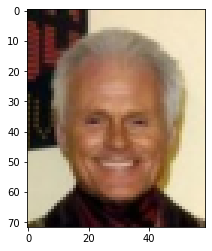

[1 1]


In [8]:
# x를 plt로 출력해보자

plt.imshow(x)
plt.show()

print(y)

In [9]:
# train, test 로드하기

train_images = celeba_small['train_images']
train_labels = celeba_small['train_labels']
test_images = celeba_small['test_images']
test_labels = celeba_small['test_labels']

In [10]:
# train이미지에서 0이 아닌 값들을 출력해보자.
train_images[train_images !=0][:10]

array([0.02352941, 0.04313725, 0.05490196, 0.01960784, 0.03921569,
       0.05490196, 0.01977401, 0.03921569, 0.05114656, 0.02352941])

In [11]:
# train 이미지의 dtype을 보자
train_images.dtype

dtype('float64')

## PreProcessing

In [12]:
# 이미지 데이터의 shape를 살펴보자

print(train_images.shape)
print(test_images.shape)

(2000, 72, 59, 3)
(200, 72, 59, 3)


In [13]:
# train, test 셋에서 각 image, label의 min, max값을 출력하는 코드를 작성

print( train_images.min(), train_images.max())
print( test_images.min(), test_images.max())

0.0 1.0
0.0 1.0


In [14]:
# labels의 shape을 바꿔보자
from keras.utils import to_categorical
train_male_labels, train_smile_labels = np.split(train_labels, 2 ,axis=1 ) # train 데이터를 2개로 자루는데 기준축을 1로 주고 자를거임 이란 뜻
print(train_male_labels.shape, train_smile_labels.shape)

# 잘 쪼개졋군
print(train_male_labels[0], train_smile_labels[0], train_labels[0])

# 테스트 데이터에도 적용하자
test_male_labels, test_smile_labels = np.split(test_labels, 2, axis=1)

# 현재까지 한것은 (배치,2) -> (배치,1),(배치,1) 로 한 것임

(2000, 1) (2000, 1)
[0] [0] [0 0]


In [15]:
# 이제 원핫으로 바꾸자
train_male_labels = to_categorical(train_male_labels)
train_smile_labels = to_categorical(train_smile_labels)
test_male_labels = to_categorical(test_male_labels)
test_smile_labels = to_categorical(test_smile_labels)

In [16]:
# 위의 label을 (배치,4)로 합쳐보자
# 즉 (배치, 여자, 남자, 안웃음, 웃음) 으로 표현
train_labels2 = np.concatenate( [ train_male_labels, train_smile_labels], axis=1)
test_labels2 = np.concatenate( [ test_male_labels, test_smile_labels], axis=1)

In [17]:
train_labels2.shape, test_labels2.shape

((2000, 4), (200, 4))

## Visualization

In [18]:
# train 이미지 5장을 (5,h,w,3)의 shape을 출력

train_images[:5].shape

(5, 72, 59, 3)

In [19]:
# 이 5장을 (h, w*5*3)의 shape로 변경

np.hstack(train_images[:5]).shape

(72, 295, 3)

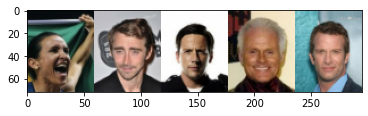

In [20]:
# 위 작업한 것을 출력
plt.imshow(np.hstack(train_images[:5]))
plt.show()

In [21]:
print(train_labels2[:5])

[[1. 0. 1. 0.]
 [0. 1. 0. 1.]
 [0. 1. 1. 0.]
 [0. 1. 0. 1.]
 [0. 1. 0. 1.]]


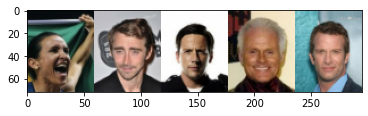

In [22]:
# transpose를 사용해서 해보자

train_images[:5].transpose((1,0,2,3)).reshape((72,-1,3)).shape
plt.imshow(train_images[:5].transpose((1,0,2,3)).reshape((72,-1,3)))
plt.show()

In [23]:
# smile, male label도 5개 출력해보자

for male, smile in zip(train_male_labels[:5], train_smile_labels[:5]) :
  print(male, smile)

[1. 0.] [1. 0.]
[0. 1.] [0. 1.]
[0. 1.] [1. 0.]
[0. 1.] [0. 1.]
[0. 1.] [0. 1.]


In [24]:
# smile, male이 몇개 있는 지 확인해보자

df = pd.DataFrame(train_labels, columns = ['gender','smile'])
df.groupby(['gender','smile']).size()

gender  smile
0       0        499
        1        507
1       0        504
        1        490
dtype: int64

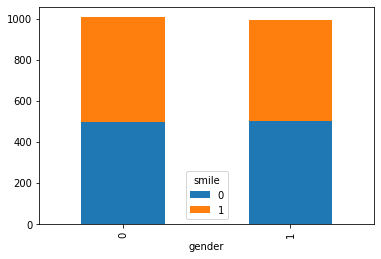

In [25]:
df.groupby(['gender','smile']).size().unstack().plot(kind='bar',stacked=True)

## 각각 모델링

In [26]:
# smile과 gender 학습셋을 각각 처리하는 이미지 classification 모델 2개를 작성하세요.
# -input : (배치, 72, 59, 3)
# -output : (배치,2)
# 위 사항을 처리할 수 있는 모양의 모델

from keras.models import Model
from keras.layers import Conv2D, MaxPool2D, Input, Flatten, Dense

In [27]:
def simple_model() :
  inputs = Input((72,59,3))

  x = Conv2D(32, 3, activation='relu')(inputs)
  x = MaxPool2D(2)(x)  # 2배 작게해줌
  x = Conv2D(64, 3, activation='relu')(x)
  x = MaxPool2D(2)(x)
  x = Conv2D(64, 3, activation='relu')(x)
  x = MaxPool2D(2)(x)

  x = Flatten()(x)
  x = Dense(64, activation='relu')(x)
  
  outputs = Dense(2, activation='softmax')(x)
  model = Model(inputs,outputs)
  return model

In [28]:
# 2개의 모델을 할당 받고 서머리를 출력해보자

gender_model = simple_model()
smile_model = simple_model()

In [29]:
gender_model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 72, 59, 3)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 70, 57, 32)        896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 35, 28, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 33, 26, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 16, 13, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 14, 11, 64)        36928     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 7, 5, 64)          0     

In [31]:
# 만든 모델에 loss와 optimizer, matrix 설정

gender_model.compile(loss = 'categorical_crossentropy', optimizer ='adam', metrics = ['accuracy'])
smile_model.compile(loss = 'categorical_crossentropy', optimizer ='adam', metrics = ['accuracy'])

In [32]:
# 만든 모델 학습
gender_hist = gender_model.fit(train_images, train_male_labels, validation_data = (test_images, test_male_labels),epochs=15, verbose=1)

Epoch 1/15
63/63 [==============================] - 31s 22ms/step - loss: 0.6606 - accuracy: 0.5809 - val_loss: 0.6176 - val_accuracy: 0.7450
Epoch 2/15
63/63 [==============================] - 1s 12ms/step - loss: 0.4849 - accuracy: 0.7682 - val_loss: 0.4410 - val_accuracy: 0.8250
Epoch 3/15
63/63 [==============================] - 1s 12ms/step - loss: 0.3377 - accuracy: 0.8583 - val_loss: 0.3295 - val_accuracy: 0.8500
Epoch 4/15
63/63 [==============================] - 1s 12ms/step - loss: 0.2509 - accuracy: 0.8899 - val_loss: 0.2783 - val_accuracy: 0.9050
Epoch 5/15
63/63 [==============================] - 1s 12ms/step - loss: 0.1676 - accuracy: 0.9289 - val_loss: 0.2310 - val_accuracy: 0.9250
Epoch 6/15
63/63 [==============================] - 1s 12ms/step - loss: 0.1188 - accuracy: 0.9535 - val_loss: 0.2410 - val_accuracy: 0.8850
Epoch 7/15
63/63 [==============================] - 1s 12ms/step - loss: 0.1079 - accuracy: 0.9536 - val_loss: 0.2612 - val_accuracy: 0.9050
Epoch 8/15
6

In [33]:
smile_hist = smile_model.fit(train_images, train_smile_labels, validation_data = (test_images, test_smile_labels),epochs=15, verbose=1)

Epoch 1/15
63/63 [==============================] - 2s 18ms/step - loss: 0.6954 - accuracy: 0.5056 - val_loss: 0.6462 - val_accuracy: 0.6250
Epoch 2/15
63/63 [==============================] - 1s 13ms/step - loss: 0.6490 - accuracy: 0.6165 - val_loss: 0.5984 - val_accuracy: 0.6650
Epoch 3/15
63/63 [==============================] - 1s 12ms/step - loss: 0.5771 - accuracy: 0.6890 - val_loss: 0.3919 - val_accuracy: 0.8400
Epoch 4/15
63/63 [==============================] - 1s 12ms/step - loss: 0.3930 - accuracy: 0.8292 - val_loss: 0.2678 - val_accuracy: 0.8900
Epoch 5/15
63/63 [==============================] - 1s 12ms/step - loss: 0.3073 - accuracy: 0.8690 - val_loss: 0.2764 - val_accuracy: 0.8850
Epoch 6/15
63/63 [==============================] - 1s 12ms/step - loss: 0.2754 - accuracy: 0.8914 - val_loss: 0.2651 - val_accuracy: 0.9000
Epoch 7/15
63/63 [==============================] - 1s 12ms/step - loss: 0.2524 - accuracy: 0.8934 - val_loss: 0.2212 - val_accuracy: 0.9100
Epoch 8/15
63

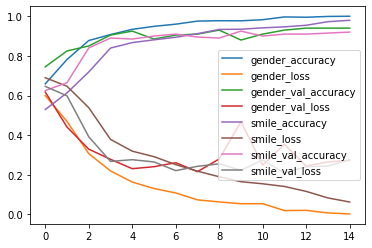

In [36]:
# 진행상황을 plt로 출력해보자

plt.plot(gender_hist.history['accuracy'], label = 'gender_accuracy')
plt.plot(gender_hist.history['loss'], label = 'gender_loss')
plt.plot(gender_hist.history['val_accuracy'], label = 'gender_val_accuracy')
plt.plot(gender_hist.history['val_loss'], label = 'gender_val_loss')

plt.plot(smile_hist.history['accuracy'], label = 'smile_accuracy')
plt.plot(smile_hist.history['loss'], label = 'smile_loss')
plt.plot(smile_hist.history['val_accuracy'], label = 'smile_val_accuracy')
plt.plot(smile_hist.history['val_loss'], label = 'smile_val_loss')

plt.legend(loc='best')
plt.show()

## Result

In [39]:
# 모델에 test_image 중 1장을 넣고 결과를 받아보자

gender_res = gender_model.predict(test_images[0:1])
gender_res.shape

(1, 2)

In [40]:
smile_res = smile_model.predict(test_images[0:1])
smile_res.shape

(1, 2)

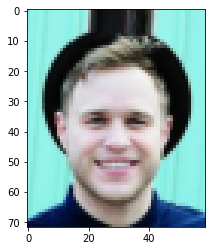

In [42]:
 # res출력
plt.imshow(test_images[0])
plt.show()

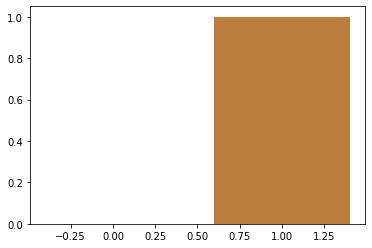

In [50]:
plt.bar(range(2), gender_res[0])
plt.bar(range(2), test_male_labels[0],alpha=0.7)
plt.show()

## Multi-ouptput Modeling

In [51]:
# 해당 학습셋을 처리하는 이미지 classification 모델을 작성해보자
from keras.layers import Concatenate

def multi_model() :
  inputs = Input((72,59,3))

  x = Conv2D(32, 3, activation='relu')(inputs)
  x = MaxPool2D(2)(x)  # 2배 작게해줌
  x = Conv2D(64, 3, activation='relu')(x)
  x = MaxPool2D(2)(x)
  x = Conv2D(64, 3, activation='relu')(x)
  x = MaxPool2D(2)(x)

  x = Flatten()(x)
  x = Dense(64, activation='relu')(x)
  
  gender_outputs = Dense(2, activation='softmax')(x)
  smile_outputs = Dense(2, activation='softmax')(x)
  outputs = Concatenate(axis=1)([gender_outputs, smile_outputs])
  
  model = Model(inputs,outputs)
  return model
  

In [53]:
multi_model().summary() 

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 72, 59, 3)]  0                                            
__________________________________________________________________________________________________
conv2d_6 (Conv2D)               (None, 70, 57, 32)   896         input_3[0][0]                    
__________________________________________________________________________________________________
max_pooling2d_6 (MaxPooling2D)  (None, 35, 28, 32)   0           conv2d_6[0][0]                   
__________________________________________________________________________________________________
conv2d_7 (Conv2D)               (None, 33, 26, 64)   18496       max_pooling2d_6[0][0]            
____________________________________________________________________________________________

In [54]:
model = multi_model()

In [55]:
# loss, optimizer, accuracy 설정
model.compile(loss = 'categorical_crossentropy', optimizer = 'adam', metrics=['accuracy'])

In [56]:
# train 이미지 학습
test_labels2.shape

(200, 4)

In [58]:
hist1 = model.fit(train_images,train_labels2, validation_data = (test_images, test_labels2), epochs=15, verbose = 1)

Epoch 1/15
63/63 [==============================] - 1s 15ms/step - loss: 1.4430 - accuracy: 0.6925 - val_loss: 2.1501 - val_accuracy: 0.6300
Epoch 2/15
63/63 [==============================] - 1s 13ms/step - loss: 1.4408 - accuracy: 0.6820 - val_loss: 2.1642 - val_accuracy: 0.6100
Epoch 3/15
63/63 [==============================] - 1s 12ms/step - loss: 1.4334 - accuracy: 0.6750 - val_loss: 2.1619 - val_accuracy: 0.6300
Epoch 4/15
63/63 [==============================] - 1s 12ms/step - loss: 1.4373 - accuracy: 0.6655 - val_loss: 2.3258 - val_accuracy: 0.6050
Epoch 5/15
63/63 [==============================] - 1s 12ms/step - loss: 1.4141 - accuracy: 0.6755 - val_loss: 2.2811 - val_accuracy: 0.5600
Epoch 6/15
63/63 [==============================] - 1s 12ms/step - loss: 1.4344 - accuracy: 0.6585 - val_loss: 2.2639 - val_accuracy: 0.6300
Epoch 7/15
63/63 [==============================] - 1s 12ms/step - loss: 1.4147 - accuracy: 0.6870 - val_loss: 2.4259 - val_accuracy: 0.5700
Epoch 8/15
63

In [59]:
def multi_model2() :
  inputs = Input((72,59,3))

  x = Conv2D(32, 3, activation='relu')(inputs)
  x = MaxPool2D(2)(x)  # 2배 작게해줌
  x = Conv2D(64, 3, activation='relu')(x)
  x = MaxPool2D(2)(x)
  x = Conv2D(64, 3, activation='relu')(x)
  x = MaxPool2D(2)(x)

  x = Flatten()(x)
  x = Dense(64, activation='relu')(x)
  
  gender_outputs = Dense(2, activation='softmax')(x)
  smile_outputs = Dense(2, activation='softmax')(x)
  #outputs = Concatenate(axis=1)([gender_outputs, smile_outputs])
  
  model = Model(inputs,[gender_outputs, smile_outputs])
  return model


In [60]:
model2 = multi_model2()

In [61]:
model2.summary()

Model: "model_4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            [(None, 72, 59, 3)]  0                                            
__________________________________________________________________________________________________
conv2d_12 (Conv2D)              (None, 70, 57, 32)   896         input_5[0][0]                    
__________________________________________________________________________________________________
max_pooling2d_12 (MaxPooling2D) (None, 35, 28, 32)   0           conv2d_12[0][0]                  
__________________________________________________________________________________________________
conv2d_13 (Conv2D)              (None, 33, 26, 64)   18496       max_pooling2d_12[0][0]           
____________________________________________________________________________________________

In [62]:
model2.compile(loss='categorical_crossentropy', optimizer='adam', metrics = ['accuracy'])

In [64]:
hist2 = model2.fit(train_images, [train_male_labels, train_smile_labels], validation_data=(test_images,[test_male_labels, test_smile_labels]), epochs=15, verbose=1)

Epoch 1/15
63/63 [==============================] - 1s 16ms/step - loss: 1.1782 - dense_11_loss: 0.5033 - dense_12_loss: 0.6749 - dense_11_accuracy: 0.7675 - dense_12_accuracy: 0.5960 - val_loss: 1.2024 - val_dense_11_loss: 0.5458 - val_dense_12_loss: 0.6566 - val_dense_11_accuracy: 0.7650 - val_dense_12_accuracy: 0.6150
Epoch 2/15
63/63 [==============================] - 1s 15ms/step - loss: 1.0768 - dense_11_loss: 0.4449 - dense_12_loss: 0.6319 - dense_11_accuracy: 0.7970 - dense_12_accuracy: 0.6490 - val_loss: 1.0910 - val_dense_11_loss: 0.4821 - val_dense_12_loss: 0.6089 - val_dense_11_accuracy: 0.8150 - val_dense_12_accuracy: 0.6850
Epoch 3/15
63/63 [==============================] - 1s 15ms/step - loss: 0.9104 - dense_11_loss: 0.3474 - dense_12_loss: 0.5630 - dense_11_accuracy: 0.8465 - dense_12_accuracy: 0.7070 - val_loss: 0.8911 - val_dense_11_loss: 0.4161 - val_dense_12_loss: 0.4749 - val_dense_11_accuracy: 0.8450 - val_dense_12_accuracy: 0.7850
Epoch 4/15
63/63 [=============

## Result

In [73]:
res = model2.predict(test_images[0:1])
res
res2 = model.predict(test_images[0:1])

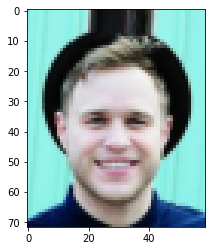

In [66]:
plt.imshow(test_images[0])
plt.show()

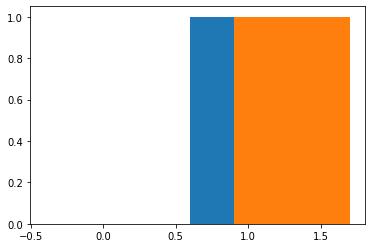

In [69]:
plt.bar(range(2), res[0][0])
plt.bar(np.array(range(2))+0.3, test_smile_labels[0])
plt.show()

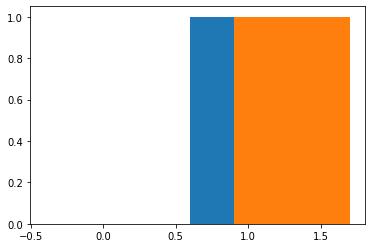

In [72]:
plt.bar(range(2), res[1][0])
plt.bar(np.array(range(2))+0.3, test_smile_labels[0])
plt.show()

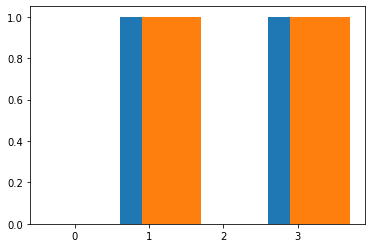

In [75]:
plt.bar(range(4), res2[0])
plt.bar(np.array(range(4))+ 0.3, test_labels2[0])
plt.show()

## 모델 분리

In [78]:
# 모델의 뒷단을 수정하여 성별 모델을 분리해보자
model2.summary()

Model: "model_4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            [(None, 72, 59, 3)]  0                                            
__________________________________________________________________________________________________
conv2d_12 (Conv2D)              (None, 70, 57, 32)   896         input_5[0][0]                    
__________________________________________________________________________________________________
max_pooling2d_12 (MaxPooling2D) (None, 35, 28, 32)   0           conv2d_12[0][0]                  
__________________________________________________________________________________________________
conv2d_13 (Conv2D)              (None, 33, 26, 64)   18496       max_pooling2d_12[0][0]           
____________________________________________________________________________________________

In [79]:
gender_model2 = Model(inputs = model2.input, outputs = model2.get_layer('dense_11').output)
gender_model2.summary()

Model: "model_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         [(None, 72, 59, 3)]       0         
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 70, 57, 32)        896       
_________________________________________________________________
max_pooling2d_12 (MaxPooling (None, 35, 28, 32)        0         
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 33, 26, 64)        18496     
_________________________________________________________________
max_pooling2d_13 (MaxPooling (None, 16, 13, 64)        0         
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 14, 11, 64)        36928     
_________________________________________________________________
max_pooling2d_14 (MaxPooling (None, 7, 5, 64)          0   

In [80]:
smile_model2 = Model(inputs = model2.input, outputs = model2.get_layer('dense_12').output)
smile_model2.summary()

Model: "model_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         [(None, 72, 59, 3)]       0         
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 70, 57, 32)        896       
_________________________________________________________________
max_pooling2d_12 (MaxPooling (None, 35, 28, 32)        0         
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 33, 26, 64)        18496     
_________________________________________________________________
max_pooling2d_13 (MaxPooling (None, 16, 13, 64)        0         
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 14, 11, 64)        36928     
_________________________________________________________________
max_pooling2d_14 (MaxPooling (None, 7, 5, 64)          0   

In [81]:
# 성별모델 테스트 데이터 확인

x = gender_model2.predict(test_images[0:1])
x.argmax()

1